In [1]:
import pandas
import konlpy
import gensim
import pandas as pd
import tensorflow as tf
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras.initializers import Constant
from gensim.models.keyedvectors import Word2VecKeyedVectors

tokenizer = Mecab() #형태소분석기는 보통 전역변수처럼 사용한다.
#불용어 프로그램적으로 컨트롤하지 않을 계획으로 전역변수로 사용한다.
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '다']
# stopwords = []
#w2v모델도 변형하지 않으므로 초기에 선언해 두겠다
word_vectors = Word2VecKeyedVectors.load('/aiffel/data/word2vec_ko.model')

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head(10)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [3]:

temp = tokenizer.pos('잘자')
print(temp)
result = [t[0] for t in temp if ('V' in t[1] or 'N' in t[1]) and 'UNKNOWN' not in t[1] and len(t[0])>1]
print(result)
for rr in temp :
    print(len(rr[1]))

[('잘', 'VA'), ('자', 'EC')]
[]
2
2


In [4]:
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data[train_data['document'].str.strip() != '']
    train_data = train_data[~train_data['document'].isin(stopwords) ]
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data[test_data['document'].str.strip() != '']
    test_data = test_data[~test_data['document'].isin(stopwords) ]
#     test_data = test_data[test_data['document'].str.strip() not in stopwords]
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
#         tagging = tokenizer.pos(sentence) # 형태소 분석
#         temp_X = [t[0] for t in tagging if ('V' in t[1] or 'N' in t[1]) and 'UNKNOWN' not in t[1] and len(t[0])>1] #형태소 분석 결과 중 명사/동사/형용사와 같은 의미있는 단어만 선택 
#         temp_X = [t[0] for t in tagging if 'UNKNOWN' not in t[1] and len(t[0])>1]
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        if len(temp_X) ==0 :
            print(sentence)
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
#         tagging = tokenizer.pos(sentence) # 형태소 분석
#         temp_X = [t[0] for t in tagging if ('V' in t[1] or 'N' in t[1]) and 'UNKNOWN' not in t[1] and len(t[0])>1] #형태소 분석 결과 중 명사/동사/형용사와 같은 의미있는 단어만 선택
#         temp_X = [t[0] for t in tagging if 'UNKNOWN' not in t[1] and len(t[0])>1]
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

    # [[YOUR CODE]]
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

잘자
가자


In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word

{0: '<PAD>',
 1: '<BOS>',
 2: '<UNK>',
 3: '<UNUSED>',
 4: '.',
 5: '영화',
 6: '고',
 7: '하',
 8: '을',
 9: '보',
 10: '..',
 11: '게',
 12: ',',
 13: '!',
 14: '지',
 15: '있',
 16: '없',
 17: '?',
 18: '좋',
 19: '나',
 20: '었',
 21: '만',
 22: '는데',
 23: '너무',
 24: '봤',
 25: '적',
 26: '안',
 27: '정말',
 28: '로',
 29: '음',
 30: '것',
 31: '아',
 32: '네요',
 33: '재밌',
 34: '어',
 35: '같',
 36: '점',
 37: '지만',
 38: '진짜',
 39: '했',
 40: '에서',
 41: '기',
 42: '네',
 43: '않',
 44: '거',
 45: '았',
 46: '수',
 47: '되',
 48: '면',
 49: 'ㅋㅋ',
 50: '말',
 51: '연기',
 52: '인',
 53: '주',
 54: '내',
 55: '최고',
 56: '~',
 57: '평점',
 58: '이런',
 59: '던',
 60: '어요',
 61: '할',
 62: '왜',
 63: '겠',
 64: '1',
 65: '스토리',
 66: '해',
 67: '습니다',
 68: 'ㅋㅋㅋ',
 69: '...',
 70: '드라마',
 71: '생각',
 72: '아니',
 73: '더',
 74: '그',
 75: '싶',
 76: '사람',
 77: '듯',
 78: '때',
 79: '감동',
 80: '함',
 81: '배우',
 82: '본',
 83: '까지',
 84: '뭐',
 85: '알',
 86: '만들',
 87: '내용',
 88: '볼',
 89: '감독',
 90: '보다',
 91: '라',
 92: '그냥',
 93: '재미',
 94: '시간',
 9

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

>모델 구성을 위한 데이터 분석 및 가공  
데이터셋 내 문장 길이 분포  
적절한 최대 문장 길이 지정

In [7]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 최소 : ', np.min(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 3.0* np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

       

문장길이 평균 :  16.593177908834008
문장길이 최대 :  117
문장길이 최소 :  1
문장길이 표준편차 :  12.626668696164671
pad_sequences maxlen :  54
전체 문장의 0.9724423557357579%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
for tokens in total_data_text :
    if len(tokens)<3 :
        print(tokens)
        
        print(get_decoded_sentence(tokens, index_to_word))


[1, 55]
최고
[1, 498]
졸작
[1, 288]
대박
[1, 31]
아
[1, 2339]
버려
[1, 4562]
망함
[1, 1894]
안습
[1, 297]
솔직히
[1, 101]
잼
[1, 64]
1
[1, 287]
4
[1, 2]
<UNK>
[1, 33]
재밌
[1, 1367]
ㅇㅇ
[1, 1919]
쵝오
[1, 1086]
별루
[1, 2]
<UNK>
[1, 256]
굿
[1, 457]
허접
[1, 105]
재미없
[1, 2740]
♥♥♥
[1, 977]
비추
[1, 1763]
good
[1, 18]
좋
[1, 55]
최고
[1, 201]
ㅎㅎ
[1, 228]
짱
[1, 1672]
갑
[1, 2]
<UNK>
[1, 1388]
휴
[1, 762]
ㅉㅉ
[1, 175]
역시
[1, 174]
^^
[1, 482]
OOO
[1, 68]
ㅋㅋㅋ
[1, 4]
.
[1, 5882]
오오
[1, 29]
음
[1, 3702]
평이
[1, 17]
?
[1, 2]
<UNK>
[1, 2]
<UNK>
[1, 95]
지루
[1, 49]
ㅋㅋ
[1, 490]
어이없
[1, 2]
<UNK>
[1, 9]
보
[1, 9588]
bad
[1, 299]
ㅎ
[1, 170]
별로
[1, 129]
ㅋ
[1, 4018]
즐
[1, 2]
<UNK>
[1, 263]
눈물
[1, 2]
<UNK>
[1, 1723]
.......
[1, 534]
♥
[1, 1834]
당연
[1, 2]
<UNK>
[1, 831]
굳
[1, 286]
몰입
[1, 42]
네
[1, 2]
<UNK>
[1, 2101]
ㅉㅉㅉ
[1, 2]
<UNK>
[1, 5700]
평작
[1, 6361]
지못미
[1, 2]
<UNK>
[1, 2]
<UNK>
[1, 172]
명작
[1, 3961]
원주율
[1, 1230]
ㅇ
[1, 2]
<UNK>
[1, 6369]
k
[1, 2]
<UNK>
[1, 2]
<UNK>
[1, 257]
ㅠ
[1, 1255]
싸우
[1, 158]
최악
[1, 69]
...
[1, 2]
<UNK>
[1, 9705]

<UNK>
[1, 2]
<UNK>
[1, 2]
<UNK>
[1, 2072]
냄새
[1, 19]
나
[1, 6430]
33
[1, 233]
유치
[1, 4386]
‥
[1, 6382]
..;
[1, 2]
<UNK>
[1, 93]
재미
[1, 2]
<UNK>
[1, 725]
멋지
[1, 1882]
오바
[1, 2]
<UNK>
[1, 1340]
귀여워
[1, 2]
<UNK>
[1, 287]
4
[1, 8920]
호호
[1, 2]
<UNK>
[1, 2]
<UNK>
[1, 2]
<UNK>
[1, 2]
<UNK>
[1, 4154]
예뻐요
[1, 2]
<UNK>
[1, 6369]
k
[1, 2]
<UNK>
[1, 2]
<UNK>
[1, 2]
<UNK>
[1, 1967]
!!!!
[1, 2]
<UNK>
[1, 57]
평점
[1, 93]
재미
[1, 79]
감동
[1, 2]
<UNK>
[1, 4018]
즐
[1, 2]
<UNK>
[1, 3611]
꽉
[1, 1747]
호
[1, 2]
<UNK>
[1, 2]
<UNK>
[1, 2]
<UNK>
[1, 2]
<UNK>
[1, 5430]
맙소사
[1, 5540]
·
[1, 2]
<UNK>
[1, 2]
<UNK>
[1, 335]
그렇
[1, 1455]
그다지
[1, 2]
<UNK>
[1, 2]
<UNK>


긴 글은 광고글이지 않을까 싶었는데, 광고글은 잘 보이지 않는다.  
하지만 알 수 있는건, 마지막 부분만 읽어봐도 평가는 대충 보인다는 것이다.  
문장길이 최소가 0이다. 문제가 있는 데이터가 포함되어 있다는 것이다. ->3개밖에 안되서 무시하기로 했다


In [9]:
X_train = [row[-maxlen:] if len(row) > maxlen else row for row in X_train]
X_test = [row[-maxlen:] if len(row) > maxlen else row for row in X_test]
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 최소 : ', np.min(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  16.41249436867756
문장길이 최대 :  54
문장길이 최소 :  1
문장길이 표준편차 :  12.000770925940937


>keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [10]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

In [11]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   1,  31,  73, 918,   4,   4,  38, 227,  19,
        32, 747], dtype=int32)

In [12]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <BOS> 아 더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [13]:
#중복코드 제거용
def modelFitTemp(model,X_train,y_train,epochs=20) :
    # validation set 20000건 분리
    x_val = X_train[:len(X_train)//7]   
    y_val = y_train[:len(X_train)//7]

    # validation set을 제외한 나머지 
    partial_x_train = X_train[len(X_train)//7:]  
    partial_y_train = y_train[len(X_train)//7:]
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    epochs=epochs  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1)
    return history

In [14]:
#epochs에 따른 loss acc 시각화
def drawLossAccuracy(history) :
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
#     plt.figure(figsize=(20, 20))

    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    plt.clf()   # 그림을 초기화합니다
#     plt.figure(figsize=(20, 20))
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# drawLossAccuracy(history)

In [15]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
modelConv1D = tf.keras.Sequential()
modelConv1D.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
modelConv1D.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
modelConv1D.add(tf.keras.layers.MaxPooling1D(5))
modelConv1D.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
modelConv1D.add(tf.keras.layers.GlobalMaxPooling1D())
modelConv1D.add(tf.keras.layers.Dense(8, activation='relu'))
modelConv1D.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


modelConv1D.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [16]:
history = modelFitTemp(modelConv1D,X_train,y_train,epochs=20)
print(modelConv1D.evaluate(X_test,  y_test, verbose=2))

Epoch 1/20
245/245 [==============================] - 5s 7ms/step - loss: 0.5518 - accuracy: 0.6996 - val_loss: 0.4457 - val_accuracy: 0.7801
Epoch 2/20
245/245 [==============================] - 1s 5ms/step - loss: 0.4138 - accuracy: 0.8015 - val_loss: 0.4326 - val_accuracy: 0.7864
Epoch 3/20
245/245 [==============================] - 1s 5ms/step - loss: 0.3847 - accuracy: 0.8182 - val_loss: 0.4318 - val_accuracy: 0.7921
Epoch 4/20
245/245 [==============================] - 1s 5ms/step - loss: 0.3601 - accuracy: 0.8319 - val_loss: 0.4373 - val_accuracy: 0.7905
Epoch 5/20
245/245 [==============================] - 1s 5ms/step - loss: 0.3340 - accuracy: 0.8459 - val_loss: 0.4480 - val_accuracy: 0.7882
Epoch 6/20
245/245 [==============================] - 1s 5ms/step - loss: 0.3056 - accuracy: 0.8609 - val_loss: 0.4732 - val_accuracy: 0.7830
Epoch 7/20
245/245 [==============================] - 1s 5ms/step - loss: 0.2749 - accuracy: 0.8770 - val_loss: 0.4958 - val_accuracy: 0.7770
Epoch 

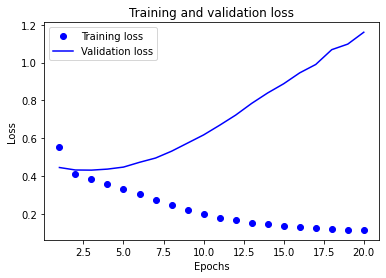

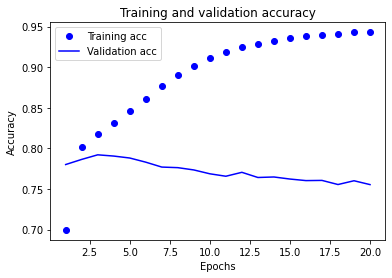

In [17]:
drawLossAccuracy(history)

In [18]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
modelLSTM = tf.keras.Sequential()
modelLSTM.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
modelLSTM.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
modelLSTM.add(tf.keras.layers.Dense(8, activation='relu'))
modelLSTM.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


modelLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = modelFitTemp(modelLSTM,X_train,y_train,epochs=20)
print(modelLSTM.evaluate(X_test,  y_test, verbose=2))

Epoch 1/20
245/245 [==============================] - 4s 8ms/step - loss: 0.4905 - accuracy: 0.7754 - val_loss: 0.3615 - val_accuracy: 0.8464
Epoch 2/20
245/245 [==============================] - 1s 6ms/step - loss: 0.3406 - accuracy: 0.8569 - val_loss: 0.3487 - val_accuracy: 0.8508
Epoch 3/20
245/245 [==============================] - 2s 6ms/step - loss: 0.3195 - accuracy: 0.8660 - val_loss: 0.3483 - val_accuracy: 0.8520
Epoch 4/20
245/245 [==============================] - 1s 6ms/step - loss: 0.3089 - accuracy: 0.8720 - val_loss: 0.3491 - val_accuracy: 0.8503
Epoch 5/20
245/245 [==============================] - 1s 6ms/step - loss: 0.3008 - accuracy: 0.8758 - val_loss: 0.3513 - val_accuracy: 0.8506
Epoch 6/20
245/245 [==============================] - 1s 6ms/step - loss: 0.2940 - accuracy: 0.8782 - val_loss: 0.3543 - val_accuracy: 0.8496
Epoch 7/20
245/245 [==============================] - 1s 6ms/step - loss: 0.2873 - accuracy: 0.8817 - val_loss: 0.3532 - val_accuracy: 0.8508
Epoch 

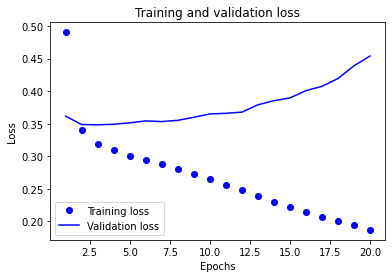

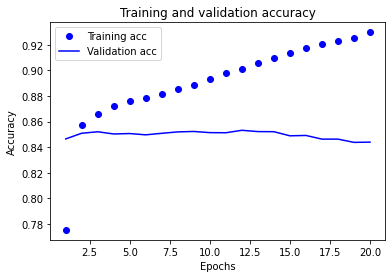

In [20]:
drawLossAccuracy(history)

In [21]:
word_vectors.wv.most_similar(positive='영화', topn=10)
#간단한 단어는 잘 학습이 되어 있는것 같다.
word_vectors.wv.most_similar(positive='가', topn=10)

[('이', 0.6746746301651001),
 ('는', 0.6698053479194641),
 ('로', 0.6634268760681152),
 ('를', 0.6199644804000854),
 ('역시', 0.6046569347381592),
 ('의', 0.60355544090271),
 ('로부터', 0.5853714942932129),
 (',', 0.5803757309913635),
 ('도', 0.5766609311103821),
 ('에', 0.5646828413009644)]

In [22]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

# 모델 구성
modelConv1Dwv = tf.keras.Sequential()
modelConv1Dwv.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
modelConv1Dwv.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
modelConv1Dwv.add(tf.keras.layers.MaxPooling1D(5))
modelConv1Dwv.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
modelConv1Dwv.add(tf.keras.layers.GlobalMaxPooling1D())
modelConv1Dwv.add(tf.keras.layers.Dense(8, activation='relu'))
modelConv1Dwv.add(tf.keras.layers.Dense(4, activation='relu'))
modelConv1Dwv.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

modelConv1Dwv.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 54, 100)           1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 48, 32)            22432     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 9, 32)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 16)             3600      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                

In [23]:
history = modelFitTemp(modelConv1Dwv,X_train,y_train,epochs=20)
print(modelConv1Dwv.evaluate(X_test,  y_test, verbose=2))

Epoch 1/20
245/245 [==============================] - 3s 8ms/step - loss: 0.6564 - accuracy: 0.6068 - val_loss: 0.6014 - val_accuracy: 0.7004
Epoch 2/20
245/245 [==============================] - 2s 6ms/step - loss: 0.5648 - accuracy: 0.7287 - val_loss: 0.5494 - val_accuracy: 0.7373
Epoch 3/20
245/245 [==============================] - 2s 7ms/step - loss: 0.5141 - accuracy: 0.7636 - val_loss: 0.5218 - val_accuracy: 0.7488
Epoch 4/20
245/245 [==============================] - 2s 6ms/step - loss: 0.4766 - accuracy: 0.7857 - val_loss: 0.5028 - val_accuracy: 0.7665
Epoch 5/20
245/245 [==============================] - 2s 6ms/step - loss: 0.4465 - accuracy: 0.8022 - val_loss: 0.4893 - val_accuracy: 0.7673
Epoch 6/20
245/245 [==============================] - 2s 6ms/step - loss: 0.4215 - accuracy: 0.8163 - val_loss: 0.4819 - val_accuracy: 0.7701
Epoch 7/20
245/245 [==============================] - 2s 6ms/step - loss: 0.3986 - accuracy: 0.8276 - val_loss: 0.4994 - val_accuracy: 0.7703
Epoch 

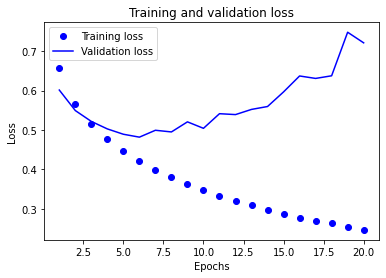

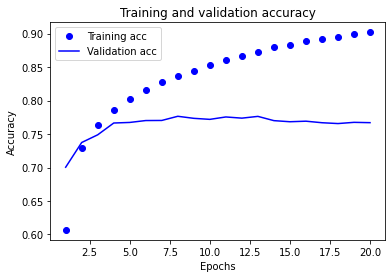

In [24]:
drawLossAccuracy(history)

In [30]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
# 모델 구성
modelLSTMvm = tf.keras.Sequential()
modelLSTMvm.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
modelLSTMvm.add(tf.keras.layers.LSTM(32))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
modelLSTMvm.add(tf.keras.layers.Dense(16, activation='relu'))
modelLSTMvm.add(tf.keras.layers.Dense(4, activation='relu'))
modelLSTMvm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

modelLSTMvm.summary()



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 54, 100)           1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 5         
Total params: 1,017,625
Trainable params: 1,017,625
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = modelFitTemp(modelLSTMvm,X_train,y_train,epochs=8)
print(modelLSTMvm.evaluate(X_test,  y_test, verbose=2))

Epoch 1/8
245/245 [==============================] - 4s 9ms/step - loss: 0.6131 - accuracy: 0.7015 - val_loss: 0.5329 - val_accuracy: 0.7964
Epoch 2/8
245/245 [==============================] - 2s 7ms/step - loss: 0.4925 - accuracy: 0.8174 - val_loss: 0.4668 - val_accuracy: 0.8287
Epoch 3/8
245/245 [==============================] - 2s 7ms/step - loss: 0.4314 - accuracy: 0.8465 - val_loss: 0.4349 - val_accuracy: 0.8400
Epoch 4/8
245/245 [==============================] - 2s 7ms/step - loss: 0.3891 - accuracy: 0.8625 - val_loss: 0.4165 - val_accuracy: 0.8440
Epoch 5/8
245/245 [==============================] - 2s 7ms/step - loss: 0.3573 - accuracy: 0.8747 - val_loss: 0.3969 - val_accuracy: 0.8487
Epoch 6/8
245/245 [==============================] - 2s 7ms/step - loss: 0.3320 - accuracy: 0.8837 - val_loss: 0.3911 - val_accuracy: 0.8510
Epoch 7/8
245/245 [==============================] - 2s 7ms/step - loss: 0.3106 - accuracy: 0.8911 - val_loss: 0.3829 - val_accuracy: 0.8468
Epoch 8/8
245

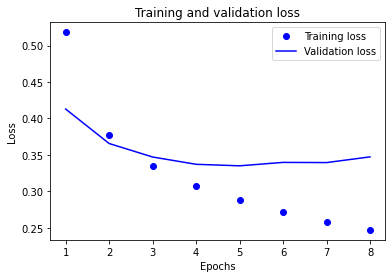

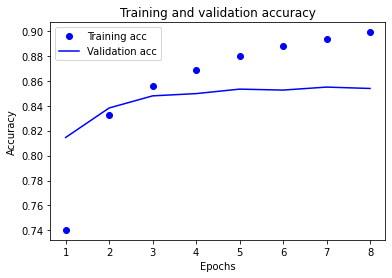

In [27]:
drawLossAccuracy(history)

w2v를 적용해보았는데 더 좋아지는 것 같지 않다.